In [76]:
# %config InlineBackend.figure_formats = ['svg']
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 220

# Cartesian coordinates centered on a point on Earth

Earth is locally flat.

This is true not only for the (surface of) the Earth, but for any so-called [Riemannian manifold](https://en.wikipedia.org/wiki/Riemannian_manifold), a generalization of surfaces to any number of dimensions. Even though there is curvature, if one zooms enough into a point, curvature disappears and their neighborhood will look flat. This is why some individuals in our planet, with a very literal narrow view, think the world is flat: they extrapolate local apparent flatness to the whole surface of the Earth. 

For every point in a manifold, there is a special coordinate system called [Riemann normal coordinates](https://en.wikipedia.org/wiki/Normal_coordinates). These coordinates translate the fact above: they represent a space that is flat -- in the sense that distances are measured via the Pythagorean theorem -- at least in a neighborhood of that point. 

To be concrete, Suppose we have Riemann normal coordinates centered on a point $P$. If we have two points with Riemann normal coordinates $A: (x_1, y_1)$ and $B: (x_2, y_2)$, then their distance will be very well approximated by 

$$d_\mathrm{Euclidean} = \sqrt{(x_1-x_2)^2+(y_1-y_2)^2}.$$

This is simply not true in other coordinate systems. As a counterexample: let us consider that $A$ and $B$ have latitudes/longitudes $(\lambda_1, \phi_1)$ and $(\lambda_2, \phi_2)$. If $R$ is the Earth's radius, and we consider the Earth to be a sphere, then the exact distance $d$ between the two points is given by the famous [haversine formula](https://en.wikipedia.org/wiki/Haversine_formula):

$$\sin^2\frac{d}{2R} = \sin^2 \frac{\lambda_1-\lambda_2}{2} + \cos\lambda_1 \cos\lambda_2\sin^2 \frac{\phi_1-\phi_2}{2}$$

This is evidently nothing like the Pythagorean theorem.

Very well: how do we **build** Riemann normal coordinates? Building them is, in fact, a very interesting exercise from a mathematical perspective -- hence we will do it below. 

### For data science: distances and neighbors

Having a localized coordinate system is useful to data science problems: we commonly deal with geospatial data, where one would like to use nearest-neighbor methods. Using the Haversine formula of course works, but is slow; it would be nice if we could just use Euclidean distances. 

Since there is nothing new under the Sun, such a coordinate system already exists: it is the [azimuthal equidistant projection](https://en.wikipedia.org/wiki/Azimuthal_equidistant_projection) in cartography, which might date back to ancient Egyptians. It is a projection used for maps, as are other more famous ones such as the [Peter's projection](https://en.wikipedia.org/wiki/Gall%E2%80%93Peters_projection) or the [Mercator projection](https://en.wikipedia.org/wiki/Mercator_projection). 

The azimuthal equidistant projection requires a central point. See below an example centered in Denver, Colorado (from [matplotlib](https://matplotlib.org/basemap/users/aeqd.html)):

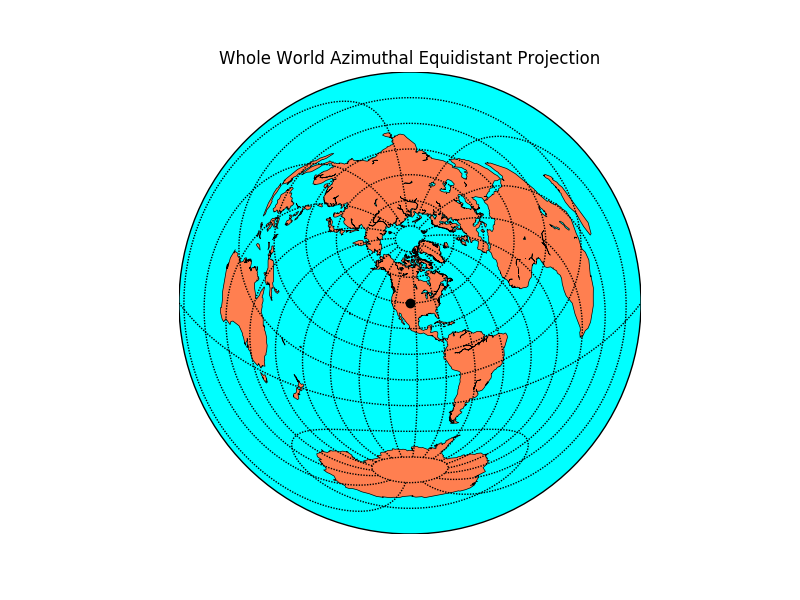

Clearly, as we get further from the center of the coordinate system, we get more distortion. Some observations:
* The distances from any point *to the center* are exact;
* The distance between any two points can be approximated by the Pythagorean theorem; however, this approximation gets worse the further they are from each other. In the map above, for example, it seems calculating distances within North America works well, but I wouldn't use this map beyond that.

# Goal

Clearly, normal coordinates look nice. Two questions naturally arise:
* Are they strictly necessary? 
* Are they *much* better than simpler coordinates? 


Our main competing system is that given by "naive" projection of a point on the sphere to a plane tangent to the sphere at some central point. 

Our goal here is then threefold:
1. Build normal coordinates (also providing a nice Python implementation)
2. Compare to (conceptually / computationally) simpler coordinate systems
3. Provide a recommendation of what coordinates to use.

It is important to notice that our analysis is very Brazil-centric; however, it is fully generalizable to other geographies.

# Setup

In all that follows, we consider a sphere of unit radius (which we can do with no loss of generality; we need only multiply all results by a physical radius later if necessary). 

I employ the physicists' convention for spherical coordinates, where $\phi$ denotes the longitude and $\theta$ is sometimes called the colatitude:
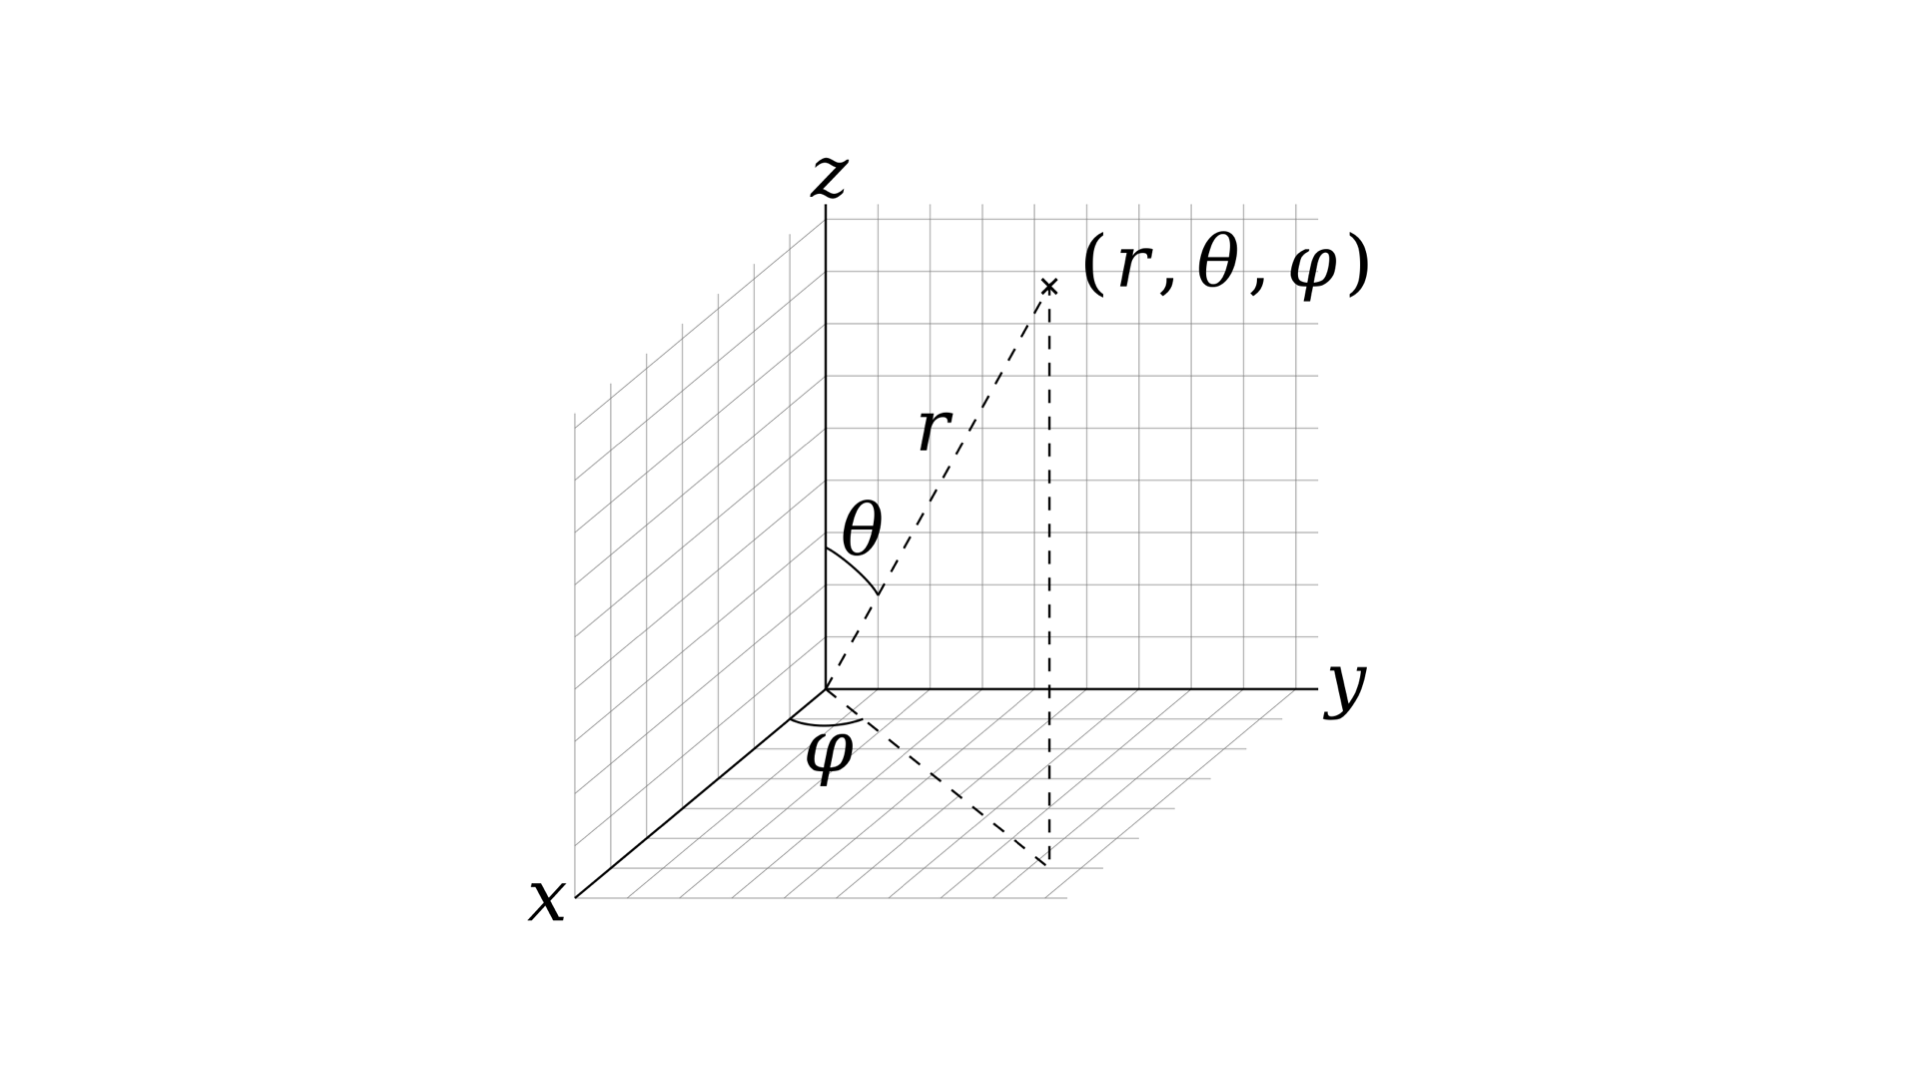

> These notations vary wildly across literature, so be careful to adapt to your convention if necessary.

Their ranges are defined as $\theta \in [0,\pi]$, $\phi \in ]-\pi, \pi]$. With these ranges, we can write the transformations to/from Cartesian coordinates as

$$\begin{cases}
x &= r\sin\theta \cos\phi \\
y &= r\sin\theta \sin\phi \\
z &= r\cos\theta 
\end{cases},\qquad \begin{cases}
r &= \sqrt{x^2+y^2+z^2}\\
\theta &= \arccos \displaystyle \frac{z}{\sqrt{x^2+y^2+z^2}}\\
\phi &= \mathrm{atan2}(y,x)
\end{cases}
$$

where we have used the [atan2](https://en.wikipedia.org/wiki/Atan2) function.

In [77]:
import numpy as np
from scipy.linalg import norm

def vector_from_spherical_coords(theta, phi):
    """Calculate Cartesian coordinates from longitude phi and colatitude theta"""
    return np.array([np.sin(theta) * np.cos(phi),
                     np.sin(theta) * np.sin(phi),
                     np.cos(theta)])

# Exponential maps: approximating surfaces by tangent planes

As a former student of General Relativity, I am a big fan of differential geometry, the area of mathematics behind all the concepts we are discussing. I will leave the technical derivation of the exponential map (and its inverse) to the Appendix, but will explain their main idea here.

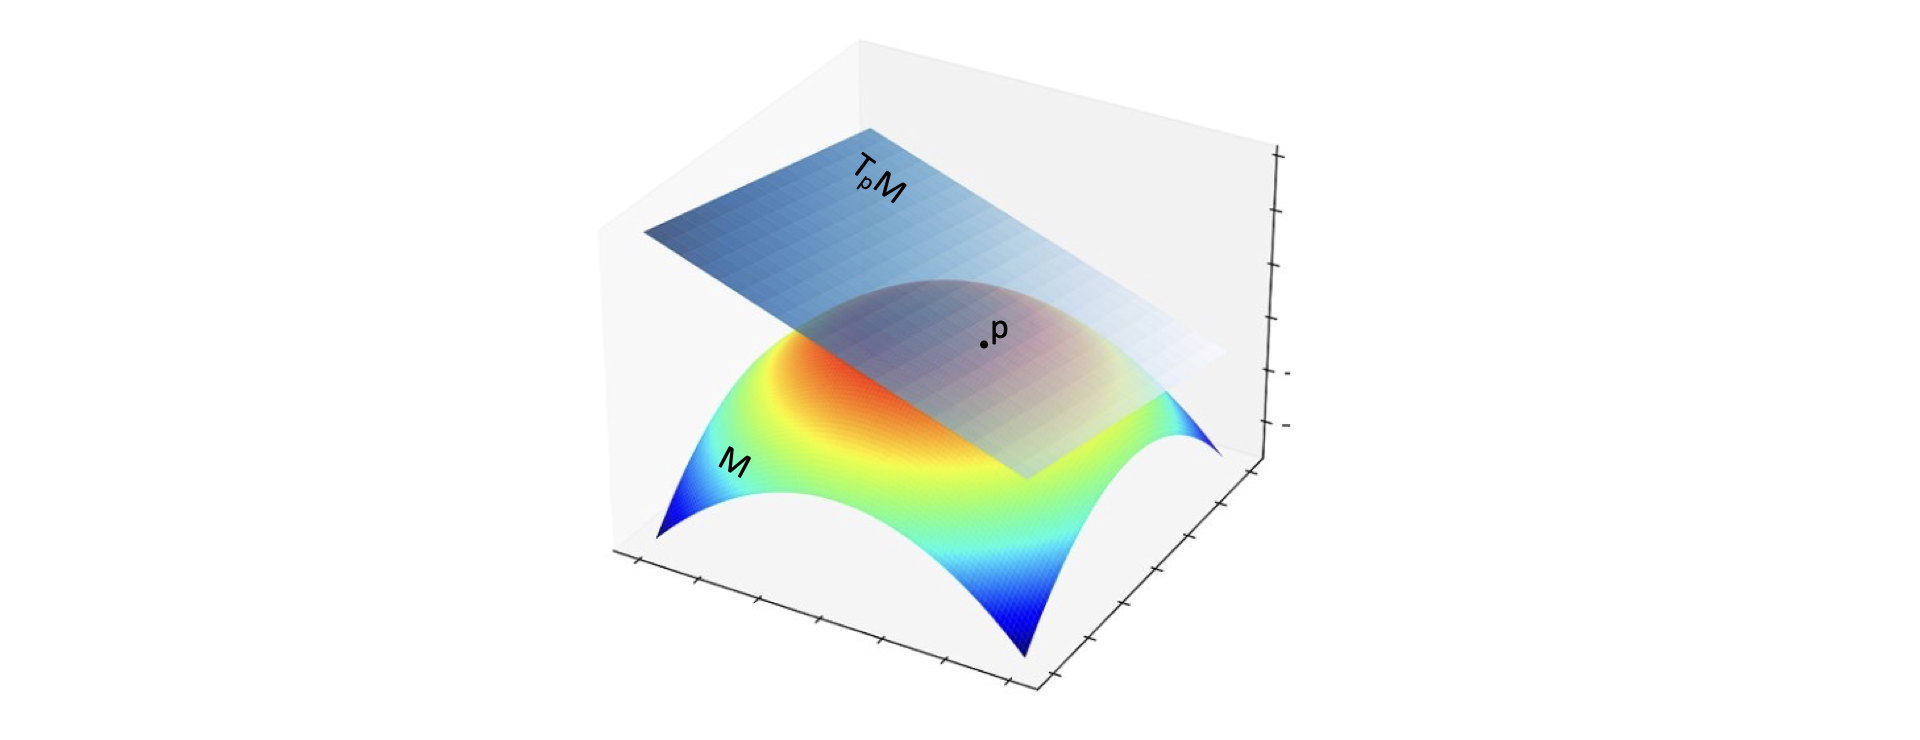

In the figure above, we have a manifold $M$ (which you can think of as a smooth curved surface) and a point $p$ on it. We build a *tangent space* (here, just a tangent plane) to $M$ at $p$, called $T_pM$, and ask the question: close to $p$, is there a 1-1 way for us to match points in the tangent space with points on the manifold?

> Tangent spaces naturally have a vector space structure: in particular, this means we can measure distances in them with the Pythagorean theorem. Thus, if we can find a smart way to connect points on the surface with points in the tangent space, we can use a simpler geometry to perform calculations.

The exponential map provides a way to do exactly that: map any point in the tangent space to the manifold in a 1-1 manner.
> First, don't let the name "exponential" fool you: unless you constantly deal with [Lie groups](https://en.wikipedia.org/wiki/Lie_group) in your daily life, this map has nothing to do with taking exponentials of numbers.

The exponential map goes one step further: distances between the central point and points in the manifold are preserved under this map. 

To better illustrate these concepts, I actually prefer to start not from the exponential map, but its *inverse*, which is more intuitive in the context of world maps.

Start with a manifold (the sphere, in our case) and consider two points, $P$ and $Q$. $P$ will be chosen as the center. The points have a distance $d$ between them, measured on the surface of the sphere.
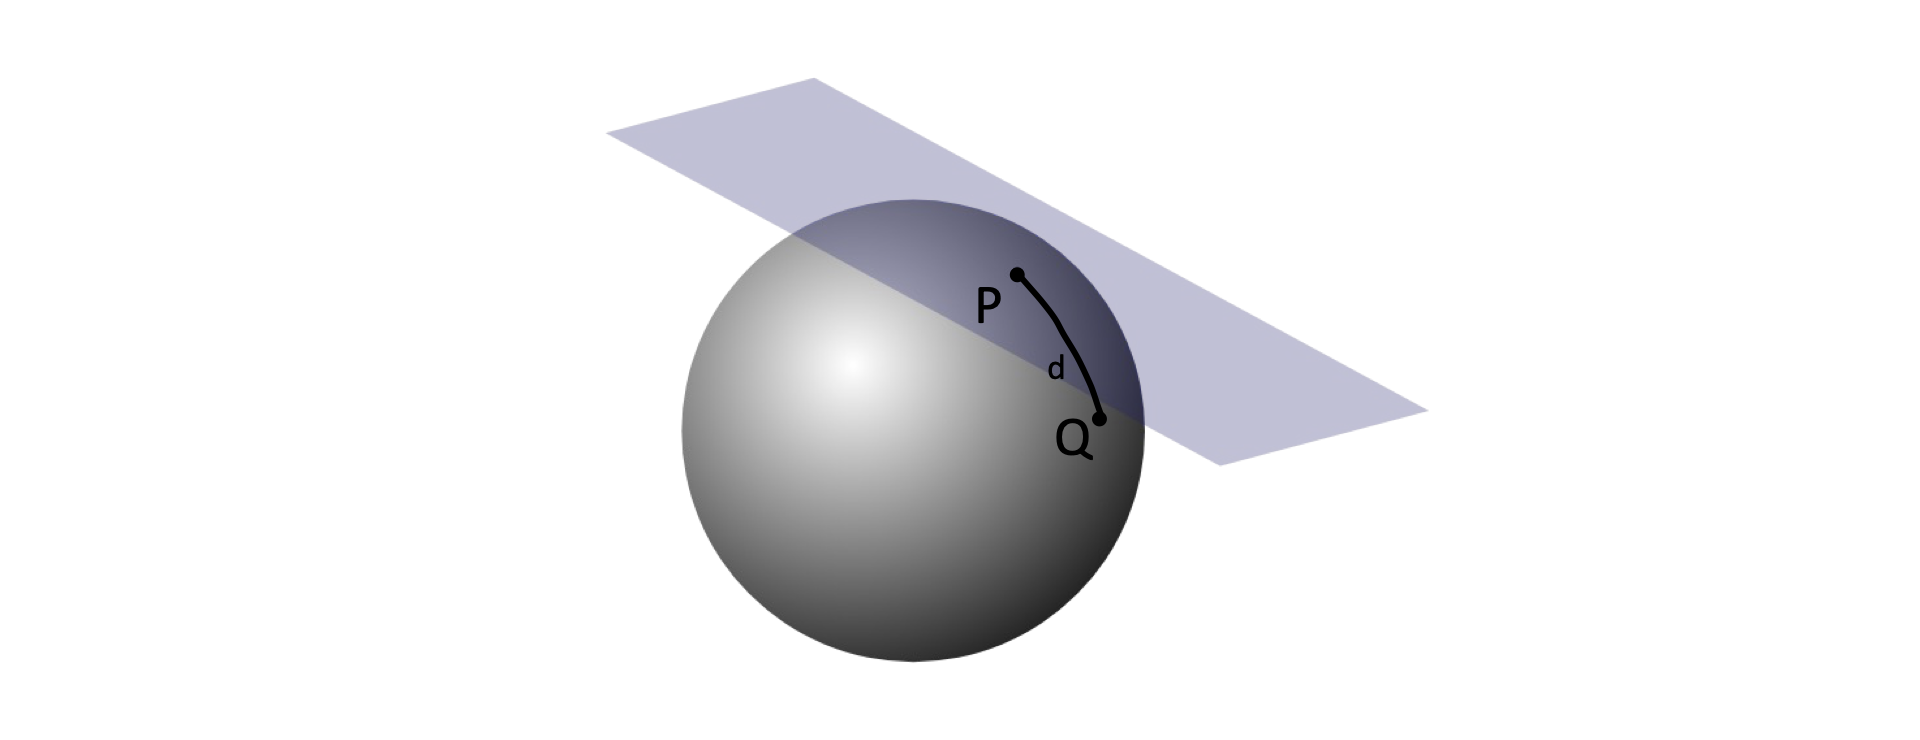

The inverse exponential map provides as way to find an equivalent point to $P$ in the tangent space, such that its distance to the origin is the same as $Q$'s distance to $P$!

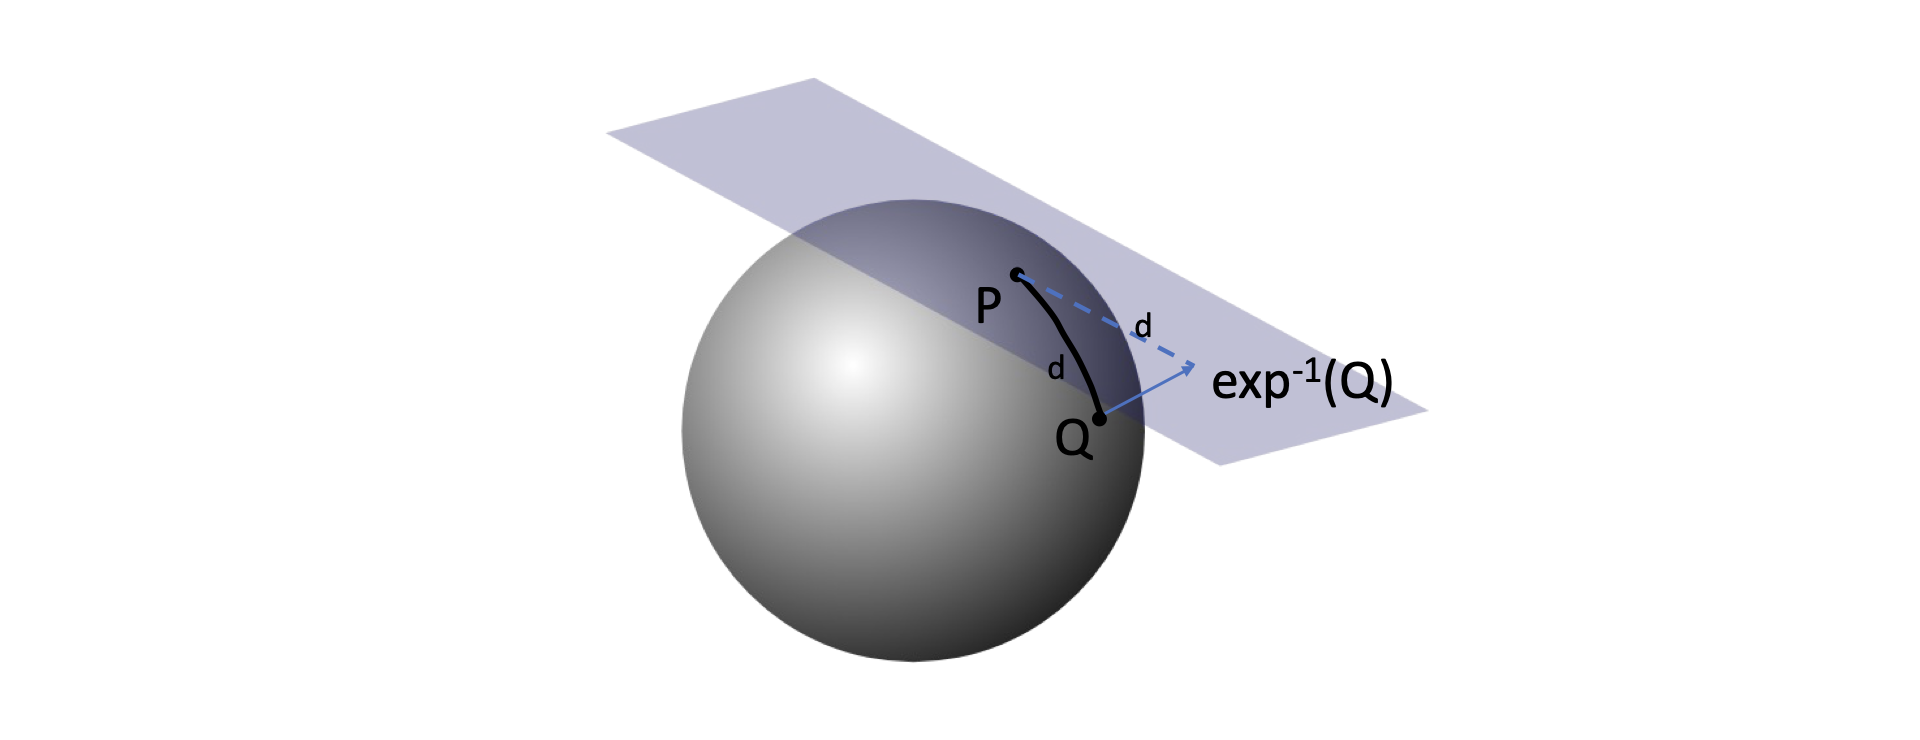

The exponential map is just the inverse: it takes points in the tangent space and projects them onto the surface, preserving distances.

> This is why I would rather call it the "proportional shadow" map: it projects the tangent space onto the manifold (like a shadow), but respecting distances from the origin.

## The (inverse) exponential map for a sphere

We show in the Appendix how exponential maps are defined in general, and derive the expressions for the sphere. Here, we lay out the results.

Any point $P$ on the unit sphere can be associated with a vector $\vec p$, satisfying $|\vec p|^2=1$. Let $Q$ be another point, with a related vector $\vec q$. Then, the inverse exponential map, which we denote as $\exp^{-1}_p$, is given by

$$\exp_p^{-1}(\vec q) = \arccos(\vec p \cdot \vec q) \frac{\vec q - (\vec p \cdot \vec q) \vec p}{|\vec q - (\vec p \cdot \vec q) \vec p|}$$

This formula looks complex, so let us break this down into parts:
* The first term $\arccos(\vec p \cdot \vec q)$ is just a cumbersome way to write the *distance* between the two points, as measured on the sphere's surface;
* $\vec q - (\vec p\cdot \vec q)\vec p$ is the component of $\vec q$ which is orthogonal to $\vec p$. We divide it by its norm so that it is a unit vector.

In other words, this gets the component of $\vec q$ perpendicular to $\vec p$ and scales it so that it has the right magnitude, which is exactly the distance between the points. Schematically,

$$\exp_p^{-1}(\vec q) = \binom{\mbox{distance between}}{\mbox{P and Q}} \times \binom{\mbox{normalized projection}}{\mbox{of $\vec q$ orthogonal to $\vec p$}}.$$

# Natural coordinates around a point on Earth's surface

Assume we used the inverse exponential map to find $\tilde q = \exp_p^{-1}(\vec q)$. What do we do next?

This is a vector in the tangent space $T_pM$. We would like to find a nice basis to write it in. A nice choice are [local tangent plane coordinates](https://en.wikipedia.org/wiki/Local_tangent_plane_coordinates), in particular **east, north, up (ENU)** coordinates, a right-handed system where the basis vectors point east, north, and towards the sky from a given reference point.

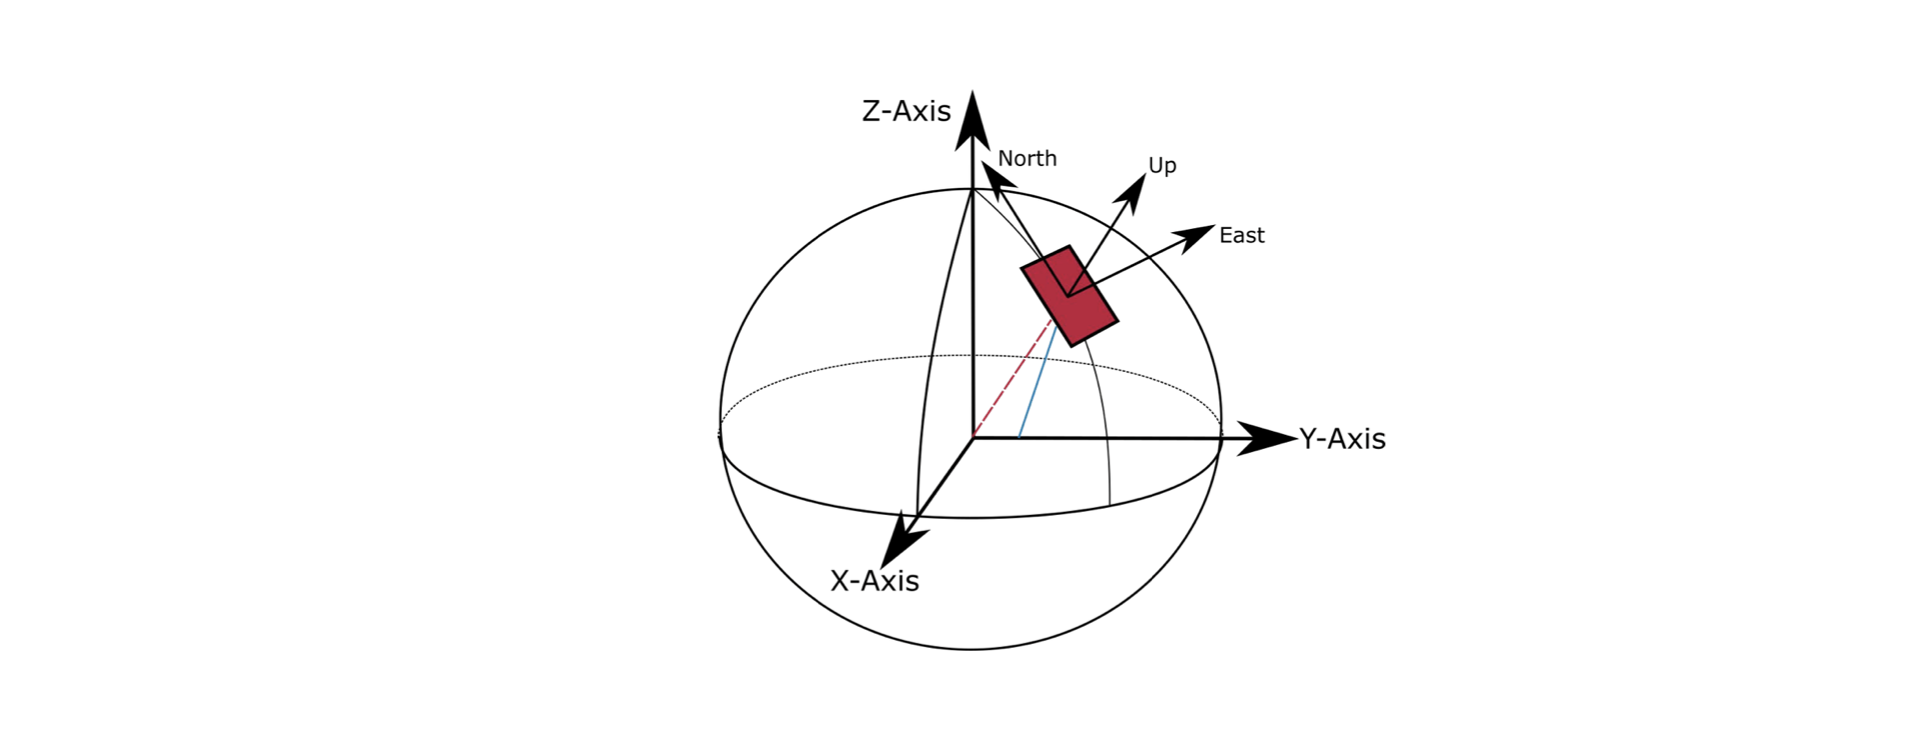

We can easily construct this coordinate system from some analytical geometry. We let $\vec k = (0,0,1)$ be the unit vector pointing from the center of the Earth towards the North Pole, ie. the "z-direction".

From our reference point $\vec p$ and $k$, we can build the ENU basis as follows. Define

$$\hat x = \frac{\vec k \times \vec p}{\vert \vec k \times \vec p\vert},\quad \hat y = \vec p \times \hat x = \frac{\vec k - (\vec p\cdot \vec k) \vec p}{\vert\vec k \times \vec p\vert}.$$


where the last equality follows from using the [triple product](https://en.wikipedia.org/wiki/Triple_product). Then $(\hat x, \hat y, p)$ are, by construction, an orthonormal basis for the whole space.
> You might want to convince yourself that $\hat x$ points eastward, and that $\hat y$ points northward.

Any vector $\vec v$ in the tangent space $T_pM$ will then have zero component along the $\vec p$ direction, and "eastward" and "northward" components

$$v_x = \vec v \cdot \hat x,\quad v_y = \vec v\cdot \hat y.$$

**These** are our Riemann normal coordinates, oriented so that our $x$ axis is nicely parallel to lines of constant latitude, and so that $y$ is aligned to lines of constant longitude.

Let us summarize the steps so far:
    
**From points on the sphere to Riemann normal coordinates:**

Inputs: a reference point $\vec p$ and any point $\vec q$ on the unit sphere
* Calculate the inverse exponential map of $\vec q$ via $$\tilde q = \exp_p^{-1}(\vec q) = \arccos(\vec p \cdot \vec q) \displaystyle \frac{\vec q - (\vec p \cdot \vec q) \vec p}{|\vec q - (\vec p \cdot \vec q) \vec p|};$$
* Construct the basis vectors $$\hat x = \frac{\vec k \times \vec p}{\vert \vec k \times \vec p\vert},\quad \hat y = \vec p \times \hat x\;$$
* Calculate $q_x = \tilde q \cdot \hat x$, $q_y = \tilde q\cdot \hat y$;
* Return $(q_x, q_y)$

There is actually a nice analytical outcome of all of this: these two formulas derived in Appendix II: if we write the 3D components of $\vec q$ and $\vec p$ as

$$\begin{align*}
q_1 &= \sin\theta \cos\phi &  p_1 &= \sin\theta_0\cos\phi_0\\
q_2 &= \sin\theta \sin\phi &  p_2 &= \sin\theta_0 \sin\phi_0\\
q_3 &= \cos\theta &  p_3 &= \cos\theta_0\\
\end{align*}$$

then

$$\binom{q_x}{q_y} = \Delta_{pq} \binom{\sin\theta \sin(\phi-\phi_0)}{\sin\theta_0 \cos\theta - \cos\theta_0 \sin\theta \cos(\phi-\phi_0)}$$

where 

$$\Delta_{pq} \equiv \cos \theta_0 \cos \theta + \sin \theta_0 \sin \theta \cos(\phi-\phi_0)$$

Here, $\Delta_{pq}$ is the arc-cosine of the distance between the two points; note that, if one takes the limit $\theta\to\theta_0, \phi\to\phi_0$ we have $\Delta_{pq} \to 1$.

These are equivalent to the formulas given in this [Wikipedia](https://en.wikipedia.org/wiki/Azimuthal_equidistant_projection#Mathematical_definition) article and are derived in the Appendices.



# Example application

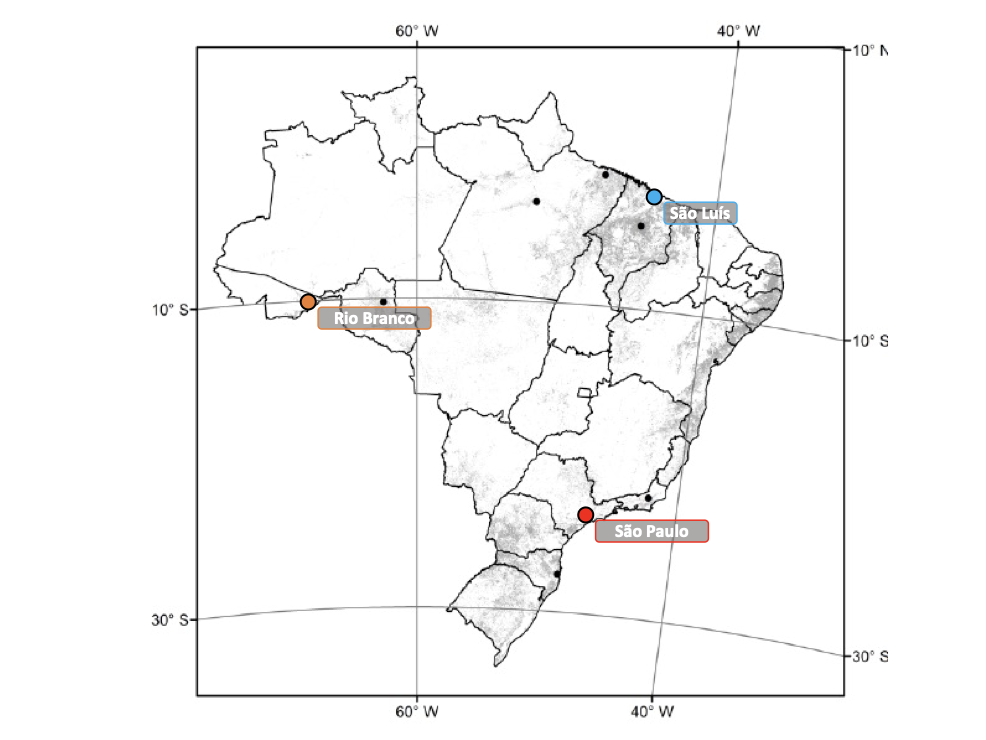

Let us choose coordinates centered in São Paulo, Brazil (red dot in the map above). It has coordinates 23.5558° S, 46.6396° W, which in our $(\theta, \phi)$ coordinates become

$$\theta_\mathrm{SP} = (90- (- 23.5558))\frac{\pi}{180} = 0.630865\pi$$

$$\phi_\mathrm{SP} = (-46.6396)\frac{\pi}{180} = -0.25911\pi$$

In [78]:
def theta_phi_from_angular_lat_lon(lat_angle, lon_angle):
    factor = np.pi/180.0
    theta = (90-lat_angle)*factor
    phi = lon_angle * factor
    return theta, phi

In [79]:
p = vector_from_spherical_coords(*theta_phi_from_angular_lat_lon(-23.5558, -46.6396))
print("Spherical coordinates of Sao Paulo:", p.round(3))

Spherical coordinates of Sao Paulo: [ 0.629 -0.666 -0.4  ]


Let us build the local basis $(\hat x, \hat y, p)$. We follow the protocol established above:


In [80]:
k = np.array([0,0,1])

## x_hat calculation
x = np.cross(k, p)
x = x/norm(x)
print("x_hat basis vector:", x.round(3))

x_hat basis vector: [ 0.727  0.687 -0.   ]


In [81]:
# y_hat calculation

y = np.cross(p, x)
print("y_hat basis vector:", y.round(3))

y_hat basis vector: [ 0.274 -0.291  0.917]


Below, we will write these inside a function that wraps everything together.

## Getting coordinates on the tangent space for any point on the sphere

Let us study the coordinates of two cities:
* São Luís, located at 2.5307° S, 44.2989° W
* Rio Branco, located at 9.9740° S, 67.8098° W

In [82]:
q_SL = vector_from_spherical_coords(*theta_phi_from_angular_lat_lon(-2.5307, -44.2989))
q_RB = vector_from_spherical_coords(*theta_phi_from_angular_lat_lon(-9.9740, -67.8098))

In [83]:
def local_tangent_plane_coordinates(p):
    """
    p: three-dimensional array containing the spherical coordinates of the reference point
    """
    import numpy as np
    from scipy.linalg import norm
    
    k = np.array([0,0,1])
    x = np.cross(k, p)
    x = x/norm(x)
    y = np.cross(p, x)
    
    def normal_coordinates(q):
        pq = np.dot(p, q)
        proj = q - pq * p
        q_ = np.arccos(pq) * proj/norm(proj)
        return np.array([q_@x, q_@y])
    
    return normal_coordinates

Let us calculate their normal coordinates, and then compare the result to that we would have obtained by naive projection onto the tangent plane.

**São Luís:**

In [84]:
normal_coords = local_tangent_plane_coordinates(p)

In [85]:
q_SL_normal_coords = normal_coords(q_SL)

In [86]:
print("Sao Luis normal coordinates:")
print(q_SL_normal_coords.round(4))

print("Sao Luis vector projected onto tangent plane coordinates:")
print([round(q_SL@x,4), round(q_SL@y,4)])

Sao Luis normal coordinates:
[0.0417 0.3667]
Sao Luis vector projected onto tangent plane coordinates:
[0.0408, 0.3584]


They are definitely close, but there is already a perceivable difference in the coordinate values; since a sphere has positive curvature, the true (great circle) distance is greater than the straight line distance. In particular, one would expect components of normal coordinates to be larger than their "flat" counterparts, and we see this phenomenon here.

**Rio Branco:**

In [87]:
q_RB_normal_coords = normal_coords(q_RB)
print("Rio Branco normal coordinates:")
print(q_RB_normal_coords.round(4))

print("Rio Branco vector projected onto tangent plane coordinates:")
print([round(q_RB@x,4), round(q_RB@y,4)])

Rio Branco normal coordinates:
[-0.3666  0.2147]
Rio Branco vector projected onto tangent plane coordinates:
[-0.3557, 0.2083]


Qualitatively, this result is in line with the previous one.

### Comparing distances

Let us use these vectors to calculate distances and see how normal coordinates are superior on that aspect.

We can obtain the great circle distance between the two points as:

$$d = 2 \arcsin \frac{|\vec p-\vec q|}{2} = \arccos(\vec p \cdot \vec q)$$

> Of course, we should multiply by the Earth's radius afterwards. We are ignoring that here.

In [88]:
def true_distance(p, q):
    return np.arccos(p@q)

**Distance of São Paulo to either city:**

Since São Paulo is the reference point for our normal coordinates, its distance to them in normal coordinates, calculated via the Pythagorean theorem, should be *exact*. 

In [89]:
d_true = true_distance(p, q_SL)
d_approx = norm(q_SL_normal_coords) # this calculates qx^2 + qy^2
d_naive = norm([q_SL@x, q_SL@y])

print("True distance Sao Paulo - Sao Luis           :", round(d_true,4))
print("Approximate distance Sao Paulo - Sao Luis    :", round(d_approx,4))
print("Naive Cartesian distance Sao Paulo - Sao Luis:", round(d_naive,4))

True distance Sao Paulo - Sao Luis           : 0.3691
Approximate distance Sao Paulo - Sao Luis    : 0.3691
Naive Cartesian distance Sao Paulo - Sao Luis: 0.3608


In [90]:
d_true = true_distance(p, q_RB)
d_approx = norm(q_RB_normal_coords) # this calculates qx^2 + qy^2
d_naive = norm([q_RB@x, q_RB@y])

print("True distance Sao Paulo - Sao Luis           :", round(d_true,4))
print("Approximate distance Sao Paulo - Sao Luis    :", round(d_approx,4))
print("Naive Cartesian distance Sao Paulo - Sao Luis:", round(d_naive,4))

True distance Sao Paulo - Sao Luis           : 0.4248
Approximate distance Sao Paulo - Sao Luis    : 0.4248
Naive Cartesian distance Sao Paulo - Sao Luis: 0.4122


In both cases, precise equality.

**Distance between São Luís and Rio Branco**

In [91]:
d_true = true_distance(q_RB, q_SL)
d_approx = norm(q_SL_normal_coords - q_RB_normal_coords)
d_naive = norm([(q_RB-q_SL)@x, (q_RB-q_SL)@y])

print("True distance Rio Branco - Sao Luis           :", round(d_true,4))
print("Approximate distance Rio Branco - Sao Luis    :", round(d_approx,4))
print("Naive Cartesian distance Rio Branco - Sao Luis:", round(d_naive,4))

True distance Rio Branco - Sao Luis           : 0.4278
Approximate distance Rio Branco - Sao Luis    : 0.4357
Naive Cartesian distance Rio Branco - Sao Luis: 0.424


Oops. In this particular case, the naive approximation is actually better!

This happens since São Paulo, the center of our coordinates, is actually pretty far from those cities (it's a bit to the Southeast). It also show that the "naive" method can still be pretty good.

# Comparison of naive projection & exponential methods over Brazil

We want to compare two 2D vectors: the one obtained from the tangent plane coordinates of $\tilde q = \exp_p^{-1} \vec q$, and the other from $\vec q$ itself. More precisely, we want to compare them as vectors in the tangent space,

$$\tilde q = (\tilde q \cdot \hat x, \tilde q \cdot \hat y),\quad q_\parallel = (\vec q \cdot \hat x, \vec q \cdot \hat y).$$

Both are parallel and differ by a factor of $\Delta_{pq}$ as defined above. The naive projection has components

$$q_\parallel = \binom{\sin\theta \sin(\phi-\phi_0)}{\sin\theta_0 \cos\theta - \cos\theta_0 \sin\theta \cos(\phi-\phi_0)}$$

and the inverse exponential map is $\Delta_{pq} q_\parallel$.

Below, we plot both coordinates for Brazil, using [GeoPandas](https://geopandas.org/en/stable/getting_started/install.html): 

/var/folders/74/9pmszzb927x5lg1pptjtnww00000gn/T/ipykernel_51876/2177999850.py:8: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world_filepath = gpd.datasets.get_path('naturalearth_lowres')


17683 points inside Brazil


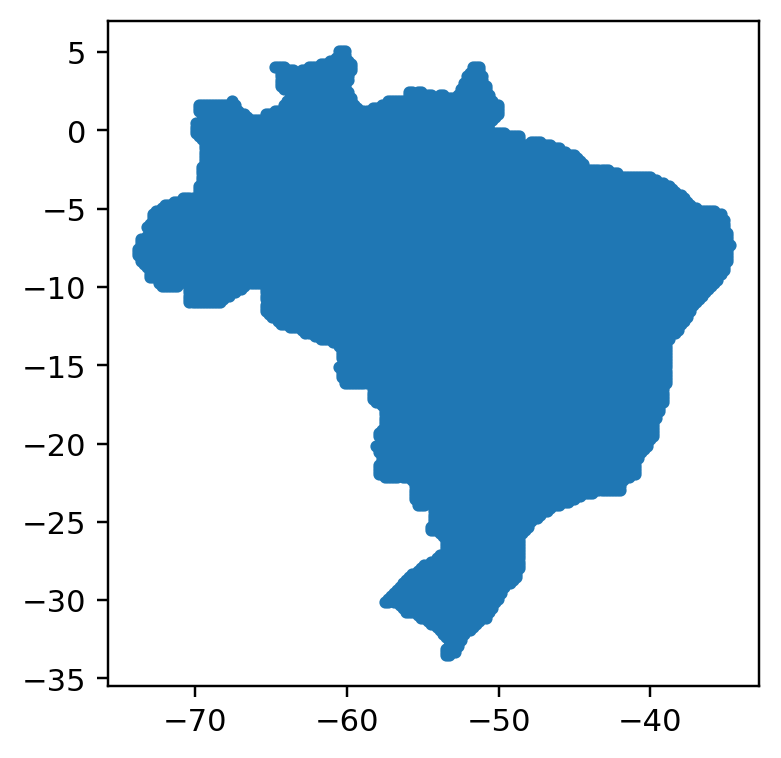

In [92]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from itertools import product

# exctract brazil shape data
world_filepath = gpd.datasets.get_path('naturalearth_lowres')
world = gpd.read_file(world_filepath)
brazil = world.loc[world['name'] == 'Brazil']

# build a dataframe containing N points inside Brazil
N = 200
shape = brazil['geometry'].iloc[0]
xmin, xmax, ymin, ymax = shape.bounds

pointdf = gpd.GeoDataFrame([{"geometry": Point(x, y)} for x, y in product(
                np.arange(xmin, xmax, (xmax - xmin) / N),
                np.arange(ymin, ymax, (ymax - ymin) / N))])

pointdf.crs = brazil.crs
pointdf = pointdf.sjoin(brazil, how="inner")
pointdf['geometry'].plot(marker='.')
print(f"{pointdf.shape[0]} points inside Brazil")

We have then almost 18000 points to work with.

The function below builds exponential map & naive projection coordinates centered on different cities: São Paulo, Rio Branco, Brasilia and Palmas:

In [93]:
def compare_projection_and_exponential_coords(p, pointdf, ax):

    import warnings
    warnings.filterwarnings('ignore', category=UserWarning, append=True)

    normal_coords = local_tangent_plane_coordinates(p)

    # also building local tangent plane basis for later comparison
    k = np.array([0,0,1])
    x = np.cross(k, p)
    x = x/norm(x)
    y = np.cross(p, x)
    
    coords = pd.DataFrame({'lat': pointdf['geometry'].apply(lambda aux: aux.y),
                       'lon': pointdf['geometry'].apply(lambda aux: aux.x)})
    
    qs = coords.apply(lambda row: vector_from_spherical_coords(np.pi/180 * (90-row[0]), np.pi/180 * row[1]), axis=1)
    qs = pd.DataFrame(qs.values.tolist(), columns=['x', 'y ', 'z'])
    

    # Projection coordinates
    naive_coords = pd.DataFrame({'x': qs@x, 'y': qs@y})
    naive_coords.plot.scatter(x='x', y='y', ax=ax, s=0.5)

    # Normal coordinates
    normal_coords_brazil = pd.DataFrame(qs.apply(normal_coords, axis=1).values.tolist(), columns=['x', 'y'])
    normal_coords_brazil.plot.scatter(x='x', y='y', ax=ax, s=0.5, color='orange', alpha=0.6)
    
    
    ax.set_aspect('equal')

    ax.scatter([0],[0], color= 'black')
    ax.legend(['Projection', 'Normal coordinates'])

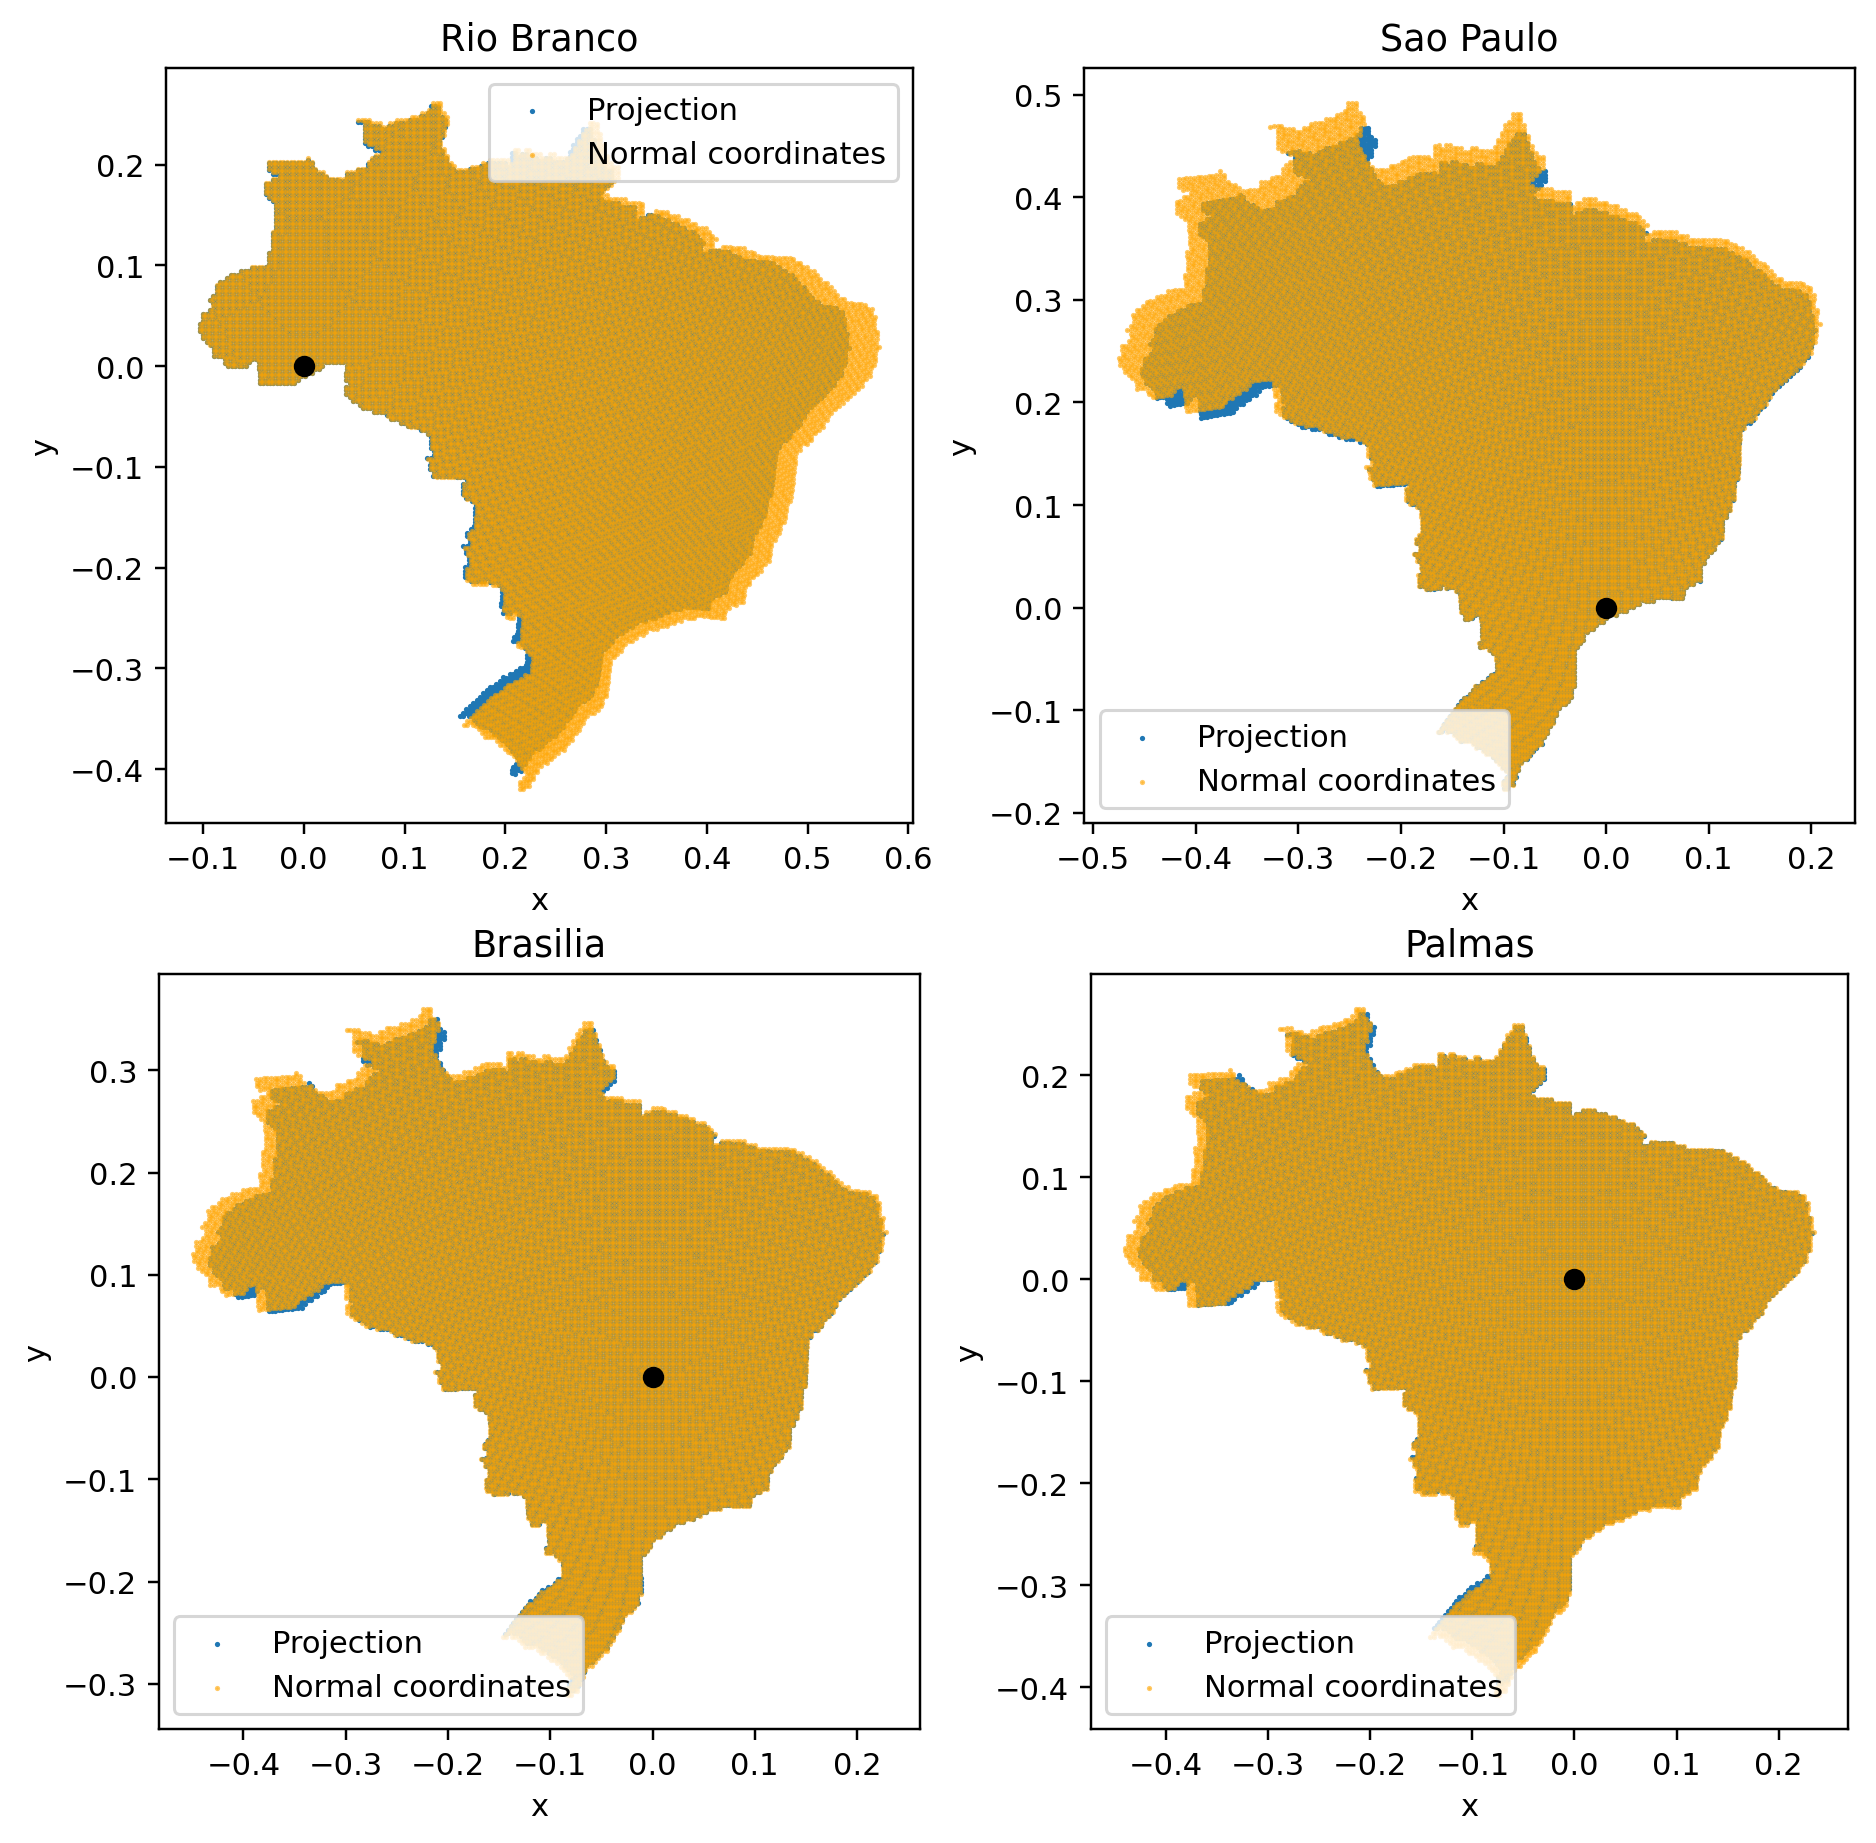

In [94]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10,10))
ax = ax.flatten()

ax[0].set_title('Rio Branco')
p = vector_from_spherical_coords(*theta_phi_from_angular_lat_lon(-9.9740, -67.8098)) # Rio Branco
compare_projection_and_exponential_coords(p, pointdf, ax[0])

ax[1].set_title('Sao Paulo')
p = vector_from_spherical_coords(*theta_phi_from_angular_lat_lon(-23.5558, -46.6396)) # Sao Paulo
compare_projection_and_exponential_coords(p, pointdf, ax[1])

ax[2].set_title("Brasilia")
p = vector_from_spherical_coords(*theta_phi_from_angular_lat_lon(-15.7975, -47.8919)) # Brasilia
compare_projection_and_exponential_coords(p, pointdf, ax[2])

ax[3].set_title("Palmas")
p = vector_from_spherical_coords(*theta_phi_from_angular_lat_lon(-10.2491, -48.3243)) # Palmas
compare_projection_and_exponential_coords(p, pointdf, ax[3])

plt.show()

We see that, as we get closer to Brazil's center of mass -- aka the centroid --  the projection and the exponential map get closer to each other.

We can, in fact, extract the centroid coordinates directly from GeoPandas:

In [95]:
print("Lat, lon:", brazil['geometry'].centroid.iloc[0])

Lat, lon: POINT (-53.05434003576711 -10.806773643498916)


> Fun fact: this is the municipality of São José do Xingu, in Mato Grosso.

Plotting coordinates centered on this guy:

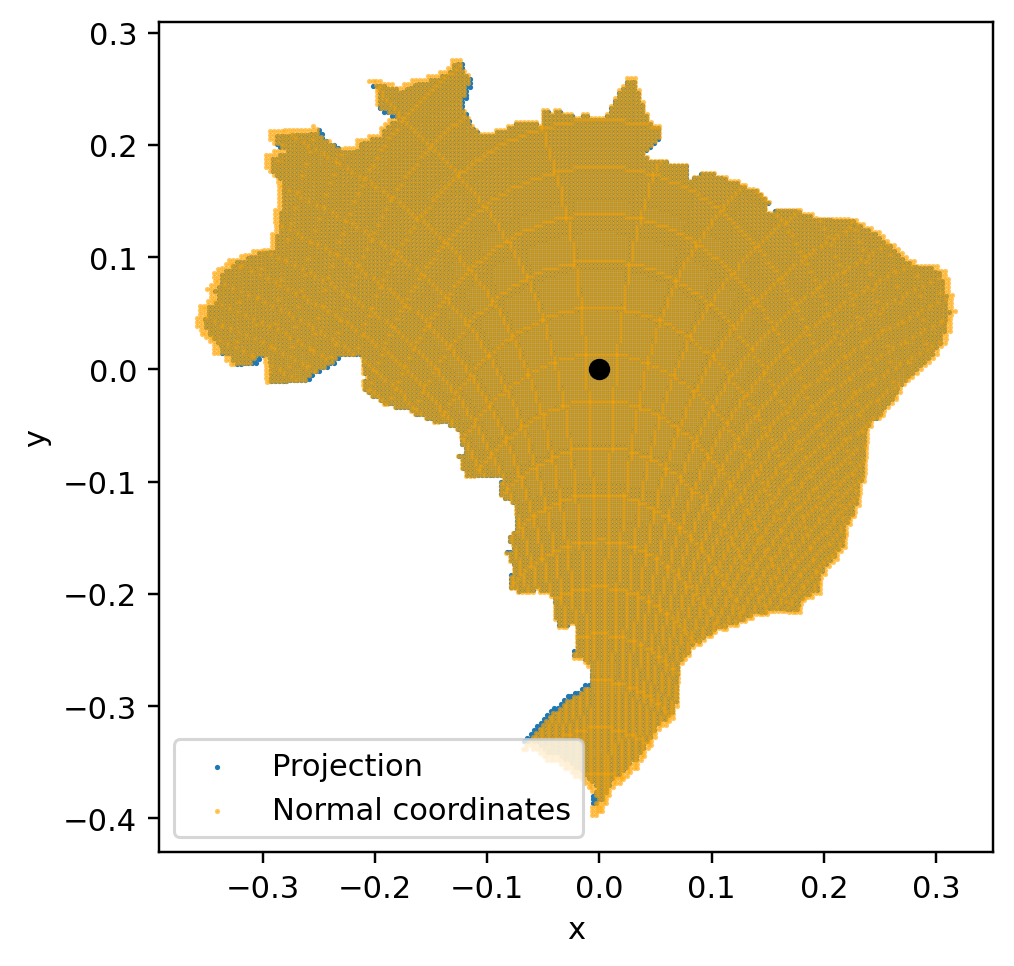

In [96]:
fig, ax = plt.subplots(figsize=(5,5))

p = vector_from_spherical_coords(*theta_phi_from_angular_lat_lon(-10.80677, -53.05434)) # Brazil's centroid
compare_projection_and_exponential_coords(p, pointdf, ax)
plt.show()

We see that using coordinates centered on Brazil's centroid essentially renders the exponential map unnecessary. Hence, **for Brazil, we can use naive projection as the best Cartesian coordinate system**, without needing to compute the full exponential map.

This is useful because we can just use the $q_\parallel$ components described above:

$$x = \sin\theta \sin(\phi-\phi_0), \quad  y = \sin\theta_0 \cos\theta - \cos\theta_0 \sin\theta \cos(\phi-\phi_0)$$

where $\theta_0, \phi_0$ refer to Brazil's centroid:

In [97]:
print("theta_0:", (90+10.80677)*np.pi/180)
print("phi_0: ", -53.05434*np.pi/180)

theta_0: 1.7594100448006442
phi_0:  -0.9259729154725285


Computing the trigonometric functions and changing colatitude to latitude, we get:

**Brazil-centric Cartesian coordinates in terms of latitude $\lambda$ and longitude $\phi$**:

$$\begin{align*}
y &= 0.982265 \sin \lambda + 0.18749 \cos\lambda \cos(\phi+0.92597)\\
x &= \cos \lambda \sin(\phi +0.92597)\\
\end{align*}$$

In [98]:
def brazil_centric_coordinates(lat, lon):
    """
    Cartesian Coordinates centered on Brazil's barycenter, built from projection of vector onto tangent plane seen in ENU coordinates.

    Parameters:
    ---------------
    lat: float or numpy array
        Latitude in radians
    lon: float or numpy array
        Longitude in radians
    """
    y = 0.982265 * np.sin(lat) + 0.18749 * np.cos(lat) * np.cos(lon+0.92597)
    x = np.cos(lat) * np.sin(lon+0.92597)
    return np.array([x,y])

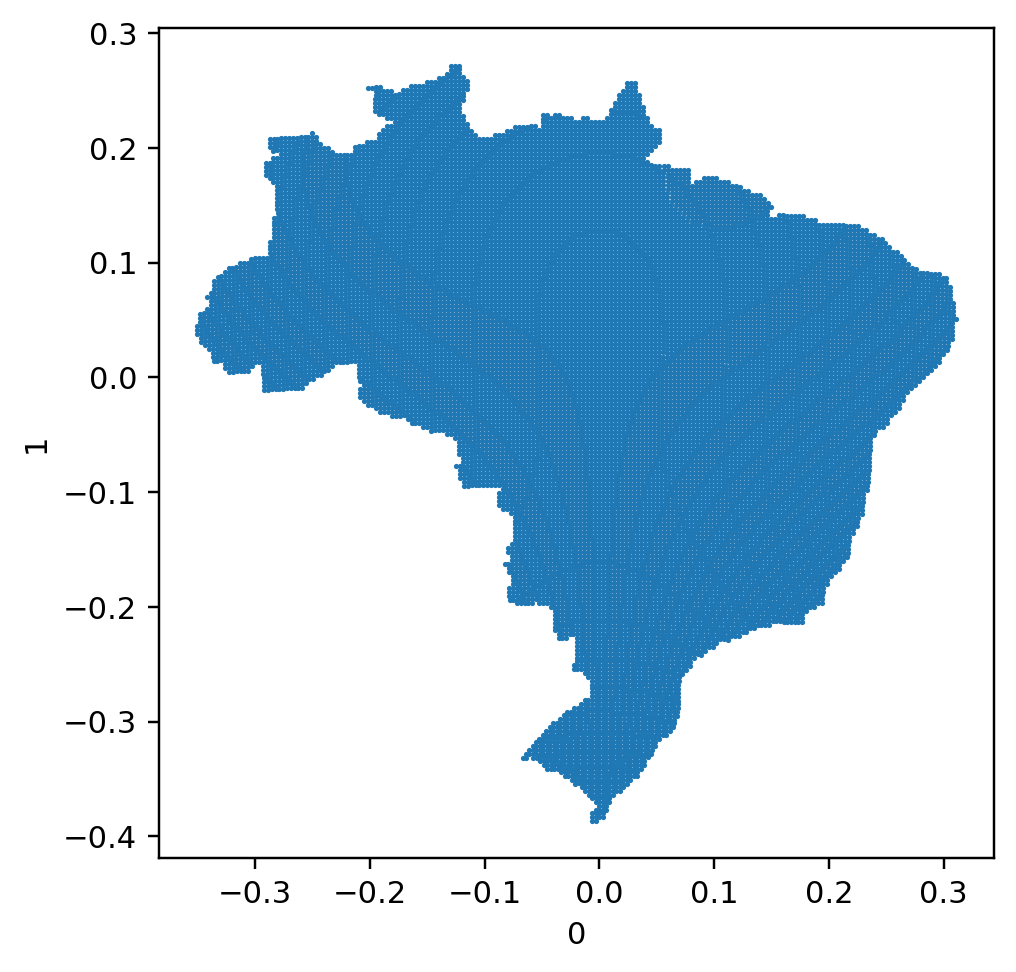

In [99]:
# plot to double-check
fig, ax = plt.subplots(figsize=(5,5))
coords = pd.DataFrame({'lat': np.pi/180 * pointdf['geometry'].apply(lambda aux: aux.y),
                       'lon': np.pi/180 * pointdf['geometry'].apply(lambda aux: aux.x)})

projection = pd.DataFrame(coords.apply(lambda row: brazil_centric_coordinates(*row), axis=1).values.tolist())
projection.plot.scatter(x=0, y=1, s=0.5, ax=ax)

plt.gca().set_aspect('equal')

# Conclusion

* We introduced the concept of the exponential map from differential geometry;
* We showed how to build coordinates from the inverse exponential map of the sphere, which is approximately Cartesian;

$$\binom{q_x}{q_y} = \Delta_{pq} \binom{\sin\theta \sin(\phi-\phi_0)}{\sin\theta_0 \cos\theta - \cos\theta_0 \sin\theta \cos(\phi-\phi_0)}$$

  with

$$\Delta_{pq} \equiv \cos \theta_0 \cos \theta + \sin \theta_0 \sin \theta \cos(\phi-\phi_0)$$

* We showed that, for Brazil, we don't need to go as far as building the exponential map -- direct projection of points onto the plane tangent to latitude -10.80677, longitude -53.05434 is enough. For a point of latitude $\lambda$ and longitude $\phi$ this becomes

$$\begin{align*}
y &= 0.982265 \sin \lambda + 0.18749 \cos\lambda \cos(\phi+0.92597)\\
x &= \cos \lambda \sin(\phi +0.92597)\\
\end{align*}$$

# References
   
* F. Alimisis, P. Davies, B. Vandereycken, and D. Alistarh, *Distributed Principal Component Analysis with Limited Communication*, Supplemental, Advances in Neural Information Processing Systems (34) (2021). Available [here](https://proceedings.neurips.cc/paper/2021/file/1680e9fa7b4dd5d62ece800239bb53bd-Supplemental.pdf)

* do Carmo, Manfredo P. (1992), Riemannian Geometry, Birkhäuser, ISBN 0-8176-3490-8. See Chapter 3.


---

# Appendix I: the exponential map of the sphere

## Riemannian definition

The exponential map in a general Riemannian manifold $(\mathcal M, g)$ is defined as follows.

Let $p \in \mathcal M$ and take any $v \in T_p \mathcal M$. Let $\gamma_(t)$ be the unique affinely-parameterized geodesic starting at $p$ with velocity $v$, ie. the solution to 

$$\begin{cases}\nabla_{\dot \gamma}\dot \gamma&=0\\ \gamma(0) &= p\\\dot \gamma(0) &=v \end{cases}$$ 

where $\nabla$ is the Levi-Civita connection associated with the metric $g$. Then, we define the exponential map by walking one unit along that geodesic:

$$\begin{align*}
\exp_p&:T_p\mathcal M\to\mathcal M\\
\exp_p(v) &:= \gamma(1)\end{align*}.$$

> More precisely, the exponential map is only defined on a neighborhood of the origin in $T_p\mathcal M$, since it might be true that, for some vectors $v$, $\gamma(1)$ is ill-defined. This might happen since the geodesic equation will have an unique solution only on an open interval. 

## Back to the sphere

The explicit formula for the exponential map on a sphere $S$ can be found if we embed the sphere in $\mathbf R^3$. Then, any point $P$ in its surface can be identified by a vector $\vec p$ with $\vert \vec p \vert=1$, where $\vert\cdot \vert$ denotes the Euclidean norm. 

Under such characterization, we can identify $T_p S$ with the set $\vec p^\perp$ of all vectors $\vec v$ that are orthogonal to $\vec p$, ie. $\vec v \cdot \vec p = 0$.

Consider then a vector $\vec v$ in $T_p S$. We may visualize it as follows: since $\vec p$ and $\vec v$ span a plane, we slice the sphere through its center, parallel to that plane. By doing so, we can convert the setup to a plane figure which is easier to work with.

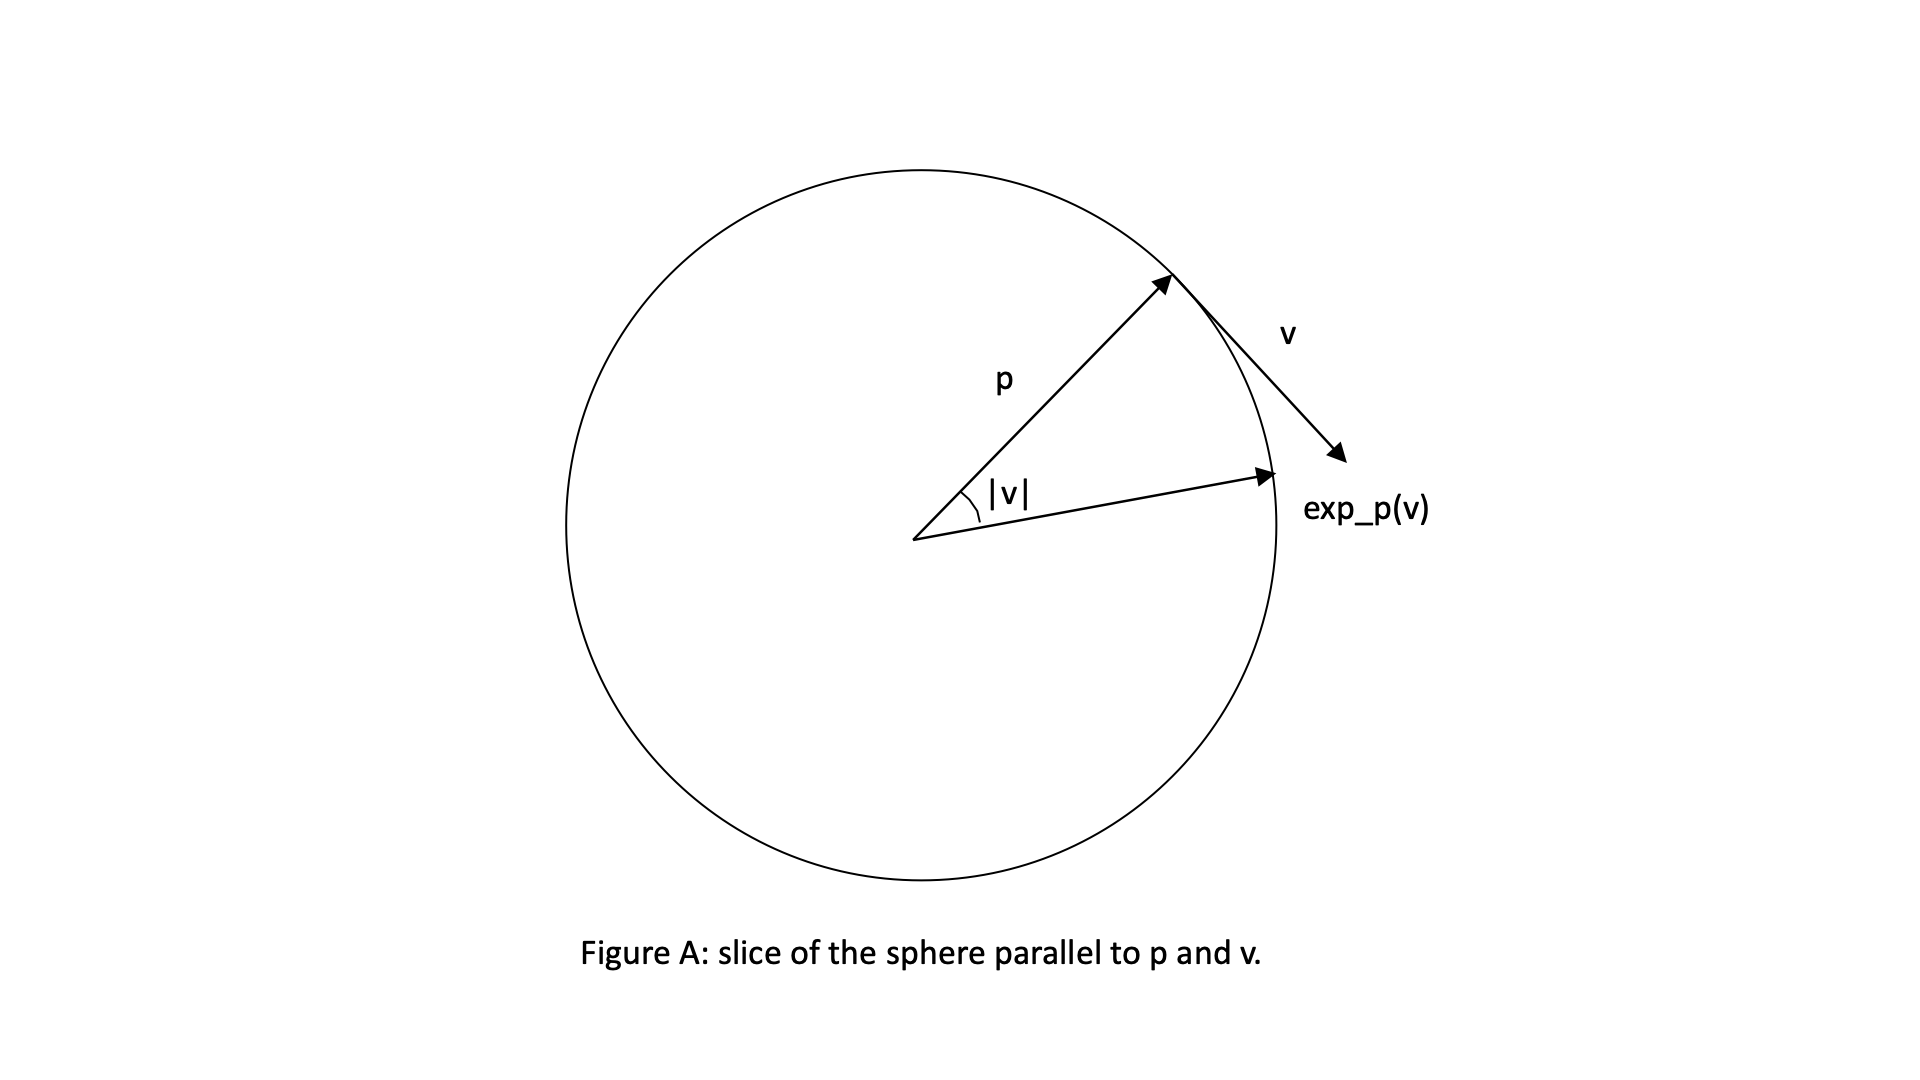

We use without proof the fact that [geodesics on a sphere are great circles](https://www.damtp.cam.ac.uk/user/reh10/lectures/nst-mmii-handout2.pdf). Hence, the solution to the geodesic equation is the circle we see in Figure A. More precisely, it is the curve starting at $\vec p$ and rotating clockwise with constant  speed $|\vec v|$.  If we call $\theta(t)$ the angle spanned by this curve(with $\theta = 0$ being point $\vec p$), then $$\theta(t) = |\vec v| t.$$The point given by $\exp_p(v)$ will then be that at $\theta(1)$, at an angular distance $|\vec v|$. In other words, it will be a rotation of $\vec p$ by an angle of $|\vec v|$ around an axis which is perpendicular to the planed spanned by $\vec v$ and $\vec p$.

We are in place to use [Rodrigues' rotation formula](https://en.wikipedia.org/wiki/Rodrigues%27_rotation_formula): $$\vec u_\mathrm{rot} = \vec u \cos \theta + \vec k \times \vec u \sin\theta + \vec k(\vec k \cdot \vec u)(1-\cos\theta),$$ where:
* $\vec u$ is the vector we want to rotate;
* $\vec k$ is the unit vector defining the axis of rotation around which we want to rotate;
* $\theta$ is the angle of rotation. 

In our case, $\vec u = \vec p$ and $\theta = |\vec v|$; the unit vector $\vec k$ can be found by clever use of the cross product, $$\vec k = \vec p \times \frac{\vec v}{|\vec v|}.$$ This can be seen to be unit-length since $|\vec p|=1$. Then, by straightforward application of the [vector triple product](https://en.wikipedia.org/wiki/Triple_product#Vector_triple_product), we find $$\vec k \times\vec u = \frac{\vec v}{|\vec v|},$$ and 
$$\exp_p(\vec v) = \vec p \cos(|\vec v|)+\frac{\vec v}{|\vec v|}\sin(|\vec v|).$$

## The inverse exponential map

We can also go the other way around. Fix $\vec p$ the same as above, and consider any other point $\vec q$ in the sphere. One might ask: what is the vector $\vec v \in T_p S$ such that $\vec q = \exp_p(\vec v)$?

We can illustrate this configuration with a figure very similar to Figure A. Here, we slice the sphere through a plane parallel to $\vec p$ and $\vec q$. Since the angular distance between them is just $\arccos \vec p \cdot \vec q$, we immediately conclude that $|\vec v| = \arccos \vec p \cdot \vec q$.
> This is well-defined as a norm, since $\arccos$ takes values in $[0, \pi]$, all positive.

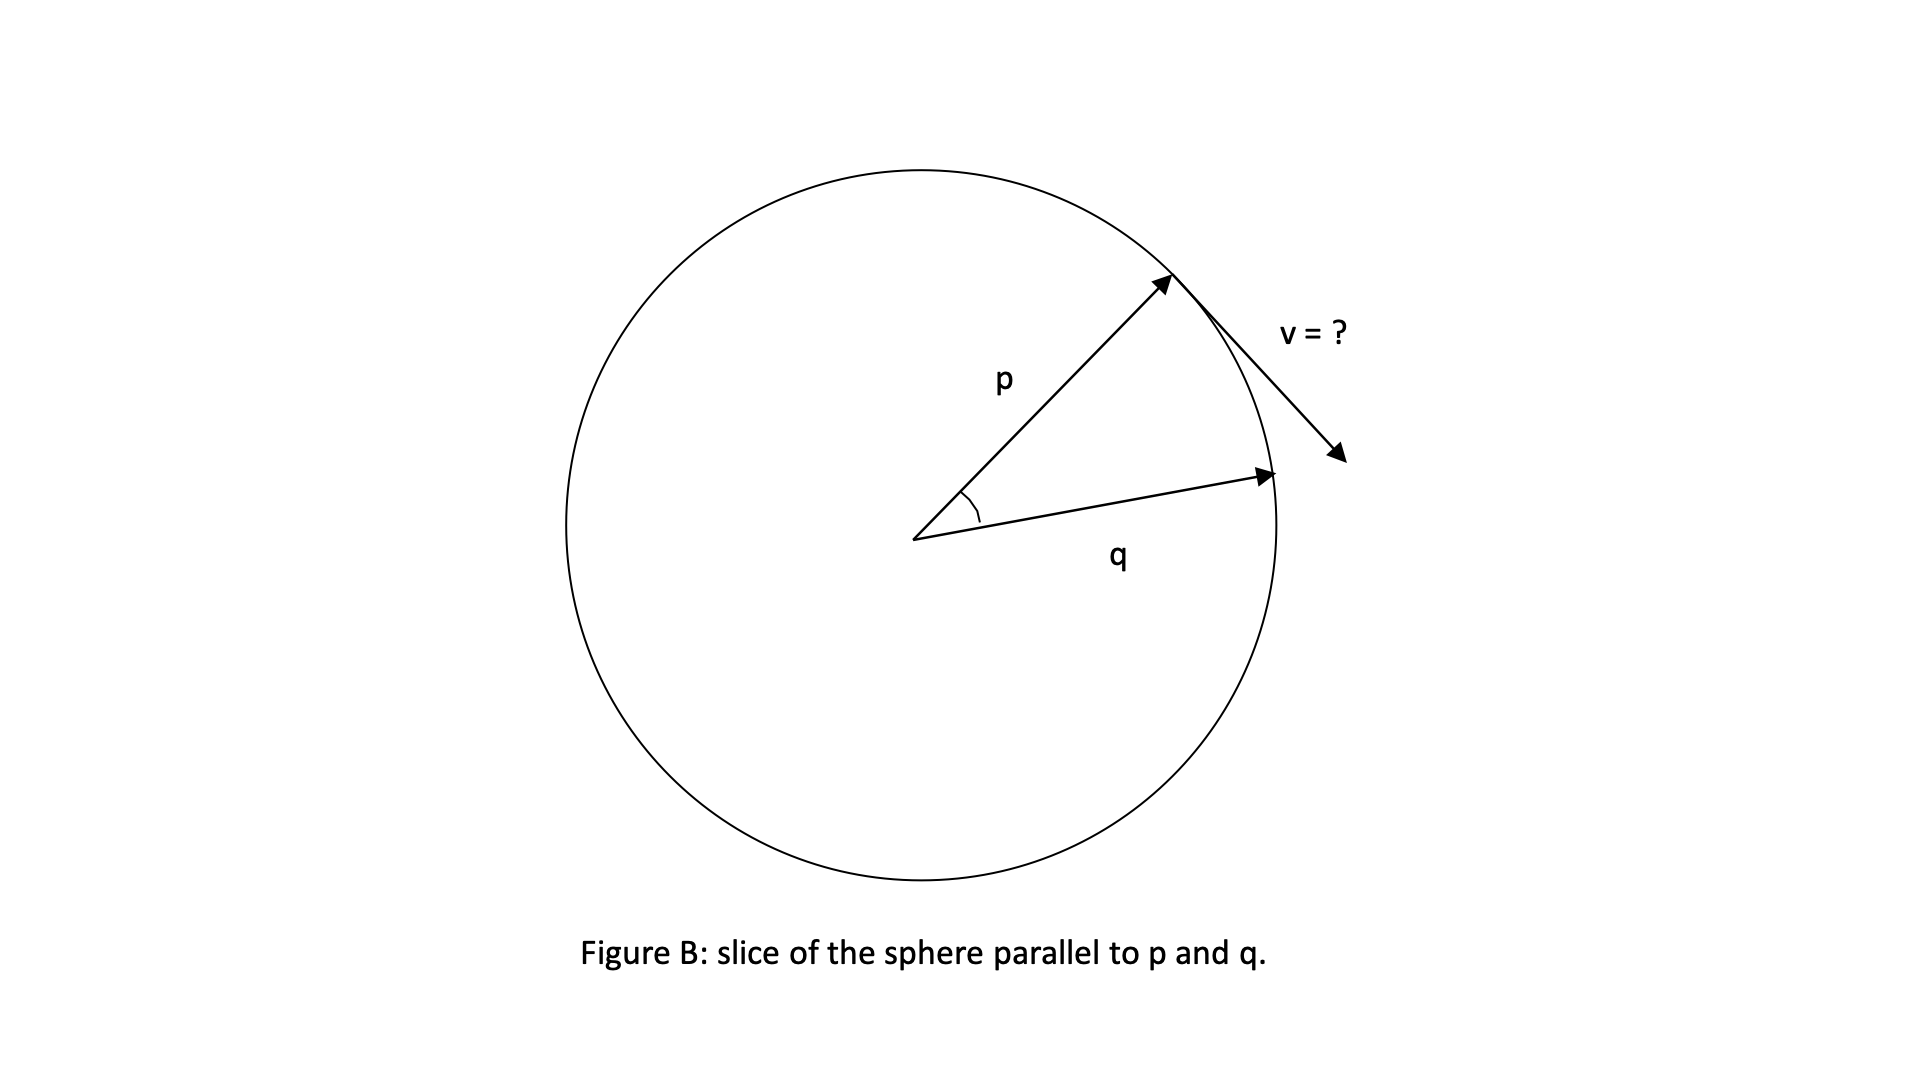

If $\vec q$ is not parallel to $\vec p$, we can find its projection onto $T_pS$ by finding its component orthogonal to $\vec p$. Since $\mathbf 1 - \vec p\otimes \vec p$ is the orthogonal projector to $\vec p$, it follows that

$$ q_\parallel \equiv (\mathbf 1 - \vec p \otimes \vec p) \cdot \vec q = \vec q-(\vec q \cdot \vec p)\vec p$$
is the orthogonal projection (we use a parallel mark because it is parallel to the tangent plane). Hence, if we define

$$\vec v = \arccos(\vec p \cdot \vec q) \frac{q_\parallel}{|q_\parallel|}$$ 

then this vector has the right length and direction, and is the inverse exponential map. 

More precisely,
$$\exp_p^{-1}(\vec q)=\arccos(\vec p\cdot \vec q)\frac{\vec q - (\vec q \cdot \vec p)\vec p}{|\vec q - (\vec q \cdot \vec p)\vec p|}.$$


This is the main result used in the text.

# Appendix II: deriving analytical expression for normal coordinates

In this section, unit vectors $\vec q$ and $\vec p$ have Cartesian coordinates

$$\begin{align*}
q_1 &= \sin\theta \cos\phi &  p_1 &= \sin\theta_0\cos\phi_0\\
q_2 &= \sin\theta \sin\phi &  p_2 &= \sin\theta_0 \sin\phi_0\\
q_3 &= \cos\theta &  p_3 &= \cos\theta_0\\
\end{align*}$$

We want to derive the equations given in [this Wikipedia article](https://en.wikipedia.org/wiki/Azimuthal_equidistant_projection). First, we change their variables to match ours: substitution of latitude by colatitude ($\phi \to\pi/2 - \theta$) and a renaming of the longitude variable($\lambda \to\phi$), their equations read

$$\cos \frac{\rho}{R} = \cos \theta_0 \cos \theta + \sin \theta_0 \sin \theta \cos(\phi-\phi_0)\quad (*)$$

and 

$$\tan \Theta = \frac{\sin \theta \sin(\phi-\phi_0)}{\sin \theta_0 \cos \theta - \cos \theta_0 \sin\theta \cos(\phi-\phi_0)}\quad (**)$$



and the coordinates are defined as $x = \rho \sin \Theta$, $y = \rho \cos \Theta$.

## A) The distance between two points

The first important result is the following:
    
$$\vec p\cdot \vec q= \cos\theta\cos\theta_0+\sin\theta\sin\theta_0 \cos(\phi-\phi_0).$$

This can be derived by straightforward substitution of the Cartesian components above, plus a fair amount of trigonometric massaging.

The distance between two points on the sphere is simply the arc-cosine of this expression.

## B) Coordinate expression of projecting vectors onto the tangent plane

First, notice that *any* vector $\vec q$ can be projected onto the tangent plane $T_p S$ via the projection operation:

$$\vec q_\parallel = \vec q - (\vec p \cdot \vec q) \vec p.$$

which identically satisfies $\vec q_\parallel \cdot \vec p = 0$.

In local coordinates, it will have components 

$$q_x = \vec q_\parallel \cdot \hat x,\quad q_y = \vec q_\parallel \cdot \hat y$$

where, as usual, 

$$\hat x = \frac{\vec k \times \vec p}{\vert \vec k \times \vec p\vert},\quad \hat y = \vec p \times \hat x$$
and $k$ is the unit vector along the $z$ direction.

We will prove that

$$\vec q_\parallel = \binom{q_x}{q_y} =  \binom{\sin\theta \sin(\phi-\phi_0)}{\sin\theta_0 \cos\theta - \cos\theta_0 \sin\theta \cos(\phi-\phi_0)}$$

(below, we drop the arrows to avoid notational clutter)

First, the expression $|k \times p|$ is just $|\sin \theta_0| = \sin\theta_0$. Writing out the expression for $q_x$, we have

In [101]:
#$$\begin{align*}
#q_x &= [q - (p\cdot q) p] \cdot \frac{k \times p}{|k\times p|}\\
#    &= \frac{1}{\sin\theta_0} q\cdot (k\times p)\\
#    &= \frac{1}{\sin\theta_0} k \cdot (p \times q)
#\end{align*}$$

using the cyclical property of the triple product in the last line. Then, we need just the $z$-component of $p
\times q$, which we can write explicitly as

In [102]:
#$$\begin{align*}
#q_x &= \frac{p_1 q_2 - p_2 q_1}{\sin\theta_0}\\
#&= \frac{\sin\theta_0 \cos\phi_0 \sin\theta\sin\phi - \sin\theta_0\sin\phi_0\sin\theta\cos\phi}{\sin\theta_0}\\
#&= \frac{\sin\theta_0\sin\theta\sin(\phi-\phi_0)}{\sin\theta_0}\\
#&= \sin\theta \sin(\phi-\phi_0).
#\end{align*}.$$


A similar calculation can be done for $q_y$. Since we can write

$$\hat y = \frac{ k - ( p\cdot  k)  p}{\vert k \times  p\vert} = \frac{ k - ( p\cdot  k)  p}{\sin\theta_0}$$

it follows that 

$$\begin{align*}
q_\parallel \cdot \hat y &=  \frac{1}{\sin\theta_0}[q_\parallel \cdot k - ( p\cdot  k) ( p \cdot q_\parallel)]\\
&= \frac{1}{\sin\theta_0} k \cdot (q_\parallel - (p \cdot q_\parallel) p)
\end{align*}$$

which is just the $z$ component of the term between brackets. For $p \cdot q_\parallel = p \cdot q$, we use the expression in Appendix II:

$$\begin{align*}
q_\parallel \cdot \hat y &= \frac{\cos\theta - \cos\theta_0[\cos\theta\cos\theta_0+\sin\theta\sin\theta_0 \cos(\phi-\phi_0)]}{\sin\theta_0}\\
&= \frac{\cos\theta(1-\cos^2\theta_0)-\sin\theta\sin\theta_0\cos\theta_0\cos(\phi-\phi_0)}{\sin\theta_0}\\
&= \sin\theta_0 \cos\theta - \cos\theta_0 \sin\theta \cos(\phi-\phi_0).
\end{align*}$$





This completes the proof.

## C) Projection and exponential map share the same angle

We are ready to derive the expressions $(*)$ and $(**)$ for the exponential map.

First: notice that, if we fix the reference point $p$, then the projection $q_\parallel$ of a vector $q$ and its inverse exponential map $\tilde q \equiv \exp_p^{-1}(q)$ are **parallel**; in fact this was used in Appendix I to derive the formula for the inverse exponential map.

Hence, the angle they make with the basis vectors $\hat x, \hat y$ are equal, and using the expressions in Appendix II.B we have

$$\tan \Theta := \frac{\hat x \cdot \tilde q}{\hat y \cdot \tilde q} = \frac{\hat x \cdot q_\parallel}{\hat y \cdot  q_\parallel} = = \frac{\sin\theta \sin(\phi-\phi_0)}{\sin\theta_0 \cos\theta - \cos\theta_0 \sin\theta \cos(\phi-\phi_0)}.$$

Formula $(**)$ is proven.

Formula $(*)$ is obvious since $\vert\tilde q\vert$ is exactly equal to the great circle distance between $p$ and $q$, which is given by $\arccos(p\cdot q)$, ie. the formula in Appendix II.A. 